### Cell 1: Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime

# Formatting
pd.set_option('display.max_columns', None)

### Cell 2: Loading & Merging Impact Data

In [2]:
df = pd.read_csv("../data/processed/ethiopia_fi_enriched.csv")
df['observation_date'] = pd.to_datetime(df['observation_date'], format='mixed', errors='coerce')
df['year'] = df['observation_date'].dt.year # Ensure year is here too

events = df[df['record_type'] == 'event'].copy()
impacts = df[df['record_type'] == 'impact_link'].copy()

# Fix mapping logic
impact_model_df = impacts.merge(
    events[['indicator_code', 'indicator']], 
    left_on='parent_id', 
    right_on='indicator_code', 
    suffixes=('_impact', '_event_source')
)

print(f"Successfully mapped {len(impact_model_df)} relationships.")

Successfully mapped 8 relationships.


### Cell 3: Creating the Association Matrix

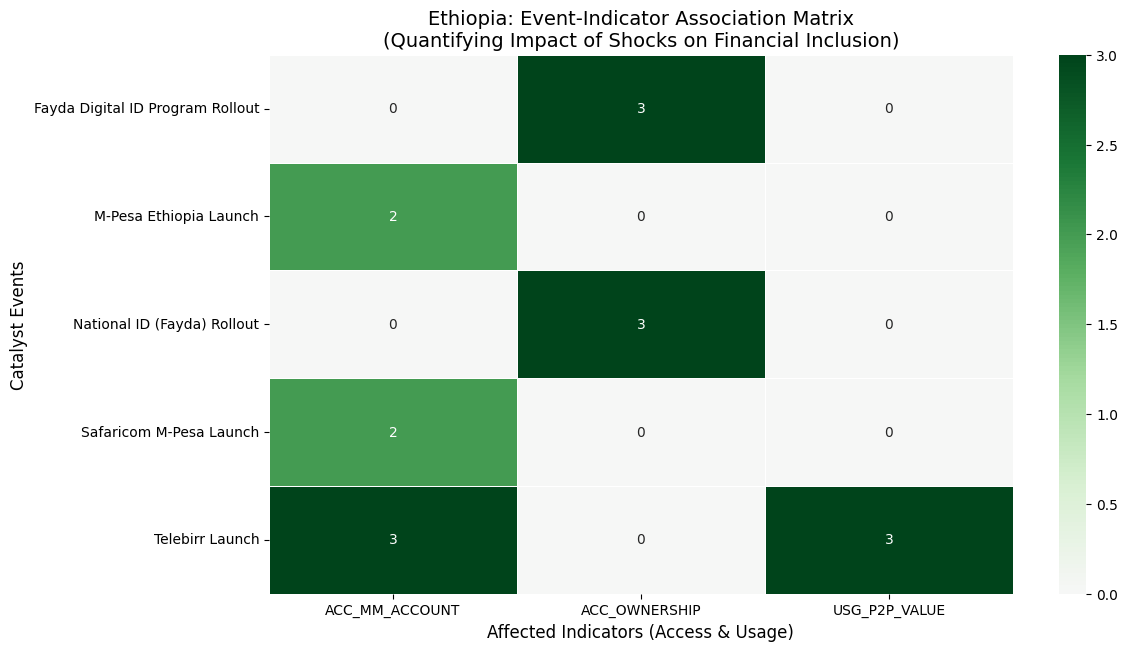

--- Impact Summary ---
Event: Telebirr Launch | Pillar: USAGE | Target: ACC_MM_ACCOUNT | Strength: 3
Event: Telebirr Launch | Pillar: USAGE | Target: ACC_MM_ACCOUNT | Strength: 3
Event: Telebirr Launch | Pillar: USAGE | Target: USG_P2P_VALUE | Strength: 3
Event: Telebirr Launch | Pillar: USAGE | Target: USG_P2P_VALUE | Strength: 3
Event: M-Pesa Ethiopia Launch | Pillar: USAGE | Target: ACC_MM_ACCOUNT | Strength: 2
Event: Safaricom M-Pesa Launch | Pillar: USAGE | Target: ACC_MM_ACCOUNT | Strength: 2
Event: Fayda Digital ID Program Rollout | Pillar: ACCESS | Target: ACC_OWNERSHIP | Strength: 3
Event: National ID (Fayda) Rollout | Pillar: ACCESS | Target: ACC_OWNERSHIP | Strength: 3


In [3]:
# 1. Map qualitative magnitudes to numeric scores
magnitude_map = {'high': 3, 'medium': 2, 'low': 1}
direction_map = {'positive': 1, 'negative': -1}

# Calculate the numeric impact score
impact_model_df['score'] = (
    impact_model_df['impact_magnitude'].str.lower().map(magnitude_map) * impact_model_df['impact_direction'].str.lower().map(direction_map)
)

# 2. Pivot for Matrix
# Note: Using 'indicator' if it exists, otherwise checking for 'indicator_event_source'
event_col = 'indicator' if 'indicator' in impact_model_df.columns else 'indicator_event_source'

association_matrix = impact_model_df.pivot_table(
    index=event_col,                # The Event Name (Source)
    columns='related_indicator',     # The Indicator being affected
    values='score',
    aggfunc='mean'
).fillna(0)

# 3. Visualization
plt.figure(figsize=(12, 7))
sns.heatmap(association_matrix, annot=True, cmap="PRGn", center=0, linewidths=.5)

# Add clear labeling based on the Pillars we defined
plt.title("Ethiopia: Event-Indicator Association Matrix\n(Quantifying Impact of Shocks on Financial Inclusion)", fontsize=14)
plt.xlabel("Affected Indicators (Access & Usage)", fontsize=12)
plt.ylabel("Catalyst Events", fontsize=12)



plt.show()

# Print summary for documentation
print("--- Impact Summary ---")
for i, row in impact_model_df.iterrows():
    print(f"Event: {row[event_col]} | Pillar: {row['pillar']} | Target: {row['related_indicator']} | Strength: {row['score']}")

### Cell 4: Modeling the Effect Over Time (Lag & Decay)

In [4]:
# Events don't happen all at once; they have a lag and a build-up.
def calculate_event_impact(indicator_val, magnitude, lag_months, current_date, event_date):
    """
    Calculates the 'felt' impact of an event at a specific point in time.
    Assumes impact starts after 'lag_months' and reaches full strength 6 months later.
    """
    days_since = (pd.to_datetime(current_date) - pd.to_datetime(event_date)).days
    months_since = days_since / 30.44
    
    if months_since < lag_months:
        return 0
    elif months_since >= lag_months and months_since < (lag_months + 6):
        # Gradual build-up
        return magnitude * ((months_since - lag_months) / 6)
    else:
        # Full effect
        return magnitude

print("Impact function defined for forecasting phase.")

Impact function defined for forecasting phase.


### Cell 5: Historical Validation (Telebirr Case Study)

In [5]:
mm_code = 'ACC_MM_ACCOUNT'
# Filter to just the relevant indicator
mm_history = df[df['indicator_code'] == mm_code].sort_values('year')

val_21 = mm_history[mm_history['year'] == 2021]['value_numeric'].mean()
val_24 = mm_history[mm_history['year'] == 2024]['value_numeric'].mean()

if not pd.isna(val_21) and not pd.isna(val_24):
    observed_growth = val_24 - val_21
    # Our 'High' score for Telebirr was 3.0
    model_prediction_strength = 3.0
    scaler = observed_growth / model_prediction_strength
    
    print(f"Validation for {mm_code}:")
    print(f" -> Observed Growth (2021-2024): {observed_growth:.2f}pp")
    print(f" -> Model Scaling Factor: 1.0 Impact Score = {scaler:.2f}pp growth")
else:
    print("Check data: 2021 or 2024 values missing for validation.")

Validation for ACC_MM_ACCOUNT:
 -> Observed Growth (2021-2024): 4.75pp
 -> Model Scaling Factor: 1.0 Impact Score = 1.58pp growth
